# Fusion des 2 modeles : Reconnaissance de text dans un formulaire
 

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo


# initialisation des variables globales
rss.init()



In [41]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\metric_orthograph.py'>

In [43]:
# MODELE DETECTION TEXTE

from doctr.models import ocr_predictor
from doctr.io import DocumentFile

DET_CKPT = "text_detection/straight_model/weights"
form_img_path = '../data/formsA-D/a01-000u.png'

straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
straight_model.det_predictor.model.load_weights(DET_CKPT)
doc = DocumentFile.from_images(form_img_path)
coords = straight_model.det_predictor(doc)

#Création du dataframe qui sera passé au second modele
df_detection = pd.DataFrame(coords[0])
df_detection = df_detection.drop(df_detection.columns[4], axis=1)
df_detection.rename(columns = {0:'y',1:'x',2:'h',3:'w'}, inplace = True)

print(coords)

2023-02-14 11:56:14.583 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\db_resnet50-adcafc63.zip
2023-02-14 11:56:17.710 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\crnn_vgg16_bn-76b7f2c6.zip


[array([[0.16210938, 0.79199219, 0.21679688, 0.80664062, 0.53864551],
       [0.30273438, 0.52929688, 0.31445312, 0.54003906, 0.32971129],
       [0.76660156, 0.51367188, 0.96386719, 0.54492188, 0.44688183],
       [0.55664062, 0.51464844, 0.7421875 , 0.54296875, 0.48003444],
       [0.45117188, 0.50976562, 0.53125   , 0.54589844, 0.64200258],
       [0.14257812, 0.50976562, 0.296875  , 0.54492188, 0.53376198],
       [0.34375   , 0.50390625, 0.43164062, 0.54882812, 0.52942014],
       [0.50488281, 0.46289062, 0.63867188, 0.49023438, 0.54146844],
       [0.42578125, 0.46289062, 0.49023438, 0.49316406, 0.59733504],
       [0.3671875 , 0.46386719, 0.41015625, 0.49121094, 0.60297602],
       [0.15039062, 0.46289062, 0.23632812, 0.4921875 , 0.53018057],
       [0.66699219, 0.4609375 , 0.72167969, 0.49707031, 0.60372669],
       [0.83691406, 0.45996094, 0.90820312, 0.49316406, 0.60707641],
       [0.25683594, 0.46191406, 0.31640625, 0.48828125, 0.52868891],
       [0.73925781, 0.45800781, 0

In [45]:

# Création du dataset pour la reconnaissance du texte : TODO prend en parametre le retour du modele de détection de texte

dataset = ld_util.get_dataset_for_prediction(file_path=form_img_path, coords=df_detection)


C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


TypeError: float() argument must be a string or a number, not 'Tensor'

In [9]:
model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

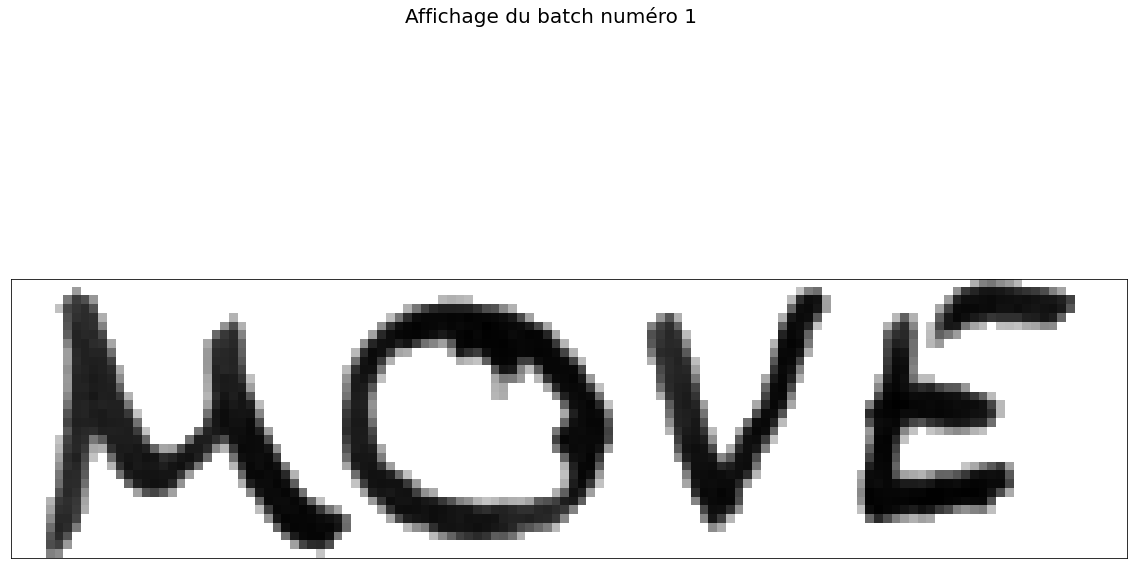

In [11]:
#TEST affichage d'un mot depuis formulaire avec dataset

batch_id=0
iterator = iter(dataset)

x = iterator.get_next()
batch_id +=1
# rd.show_iterator_batch(x,'y',batch_id, 4)

lin = 11
col = 6
fig = plt.figure(figsize=(20,12))
    
img = x[1]

plt.imshow(img,cmap='gray')
# plt.title(str(i)+' : '+str(liste_label[i]))
plt.xticks([], [])
plt.yticks([], [])
plt.suptitle('Affichage du batch numéro '+str(batch_id), size = 20);

In [12]:
# Utilisation du modele avec dataset formulaire
preds = model.predict(dataset)
mots = ld_util.greedy_decoder(preds, rss.charList)

print(mots)

4/4 [==============================] - 2s 185ms/step
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'hominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting']
